# Read the network from csv (nodes and edges)

## Imports

In [27]:
# native
import re
from functools import partial
from collections import defaultdict
import random
import itertools

# External
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import py4cytoscape as p4c

## Load the network tables
Edit the paths to match where the network tables are in your computer

In [2]:
nodes_table_path = '/home/hugo/projects/salmonella-bacterial-immunity/workflow/notebooks/nodes_cache.csv'
edges_table_path = '/home/hugo/projects/salmonella-bacterial-immunity/workflow/notebooks/edges_cache.csv'

nodes = pd.read_csv(nodes_table_path, sep=';')
nodes.head()

,id,members_locus_tags,members_count,contig_id,start,end,strand,feature,dfs_prediction,most_frq_strnd_orint,most_frq_strnd_orint_count
0,LHMLBOEB_03555,"LHMLBOEB_03555,JGKINGID_03493,JADHFFOP_00300,H...",16184,58097.9_19,19746,21710,-,ID=LHMLBOEB_03555;inference=ab initio predicti...,"padloc:name=MTase_III,system=DMS_other;defense...",-,8530
1,EJAOJOGH_03687,"EJAOJOGH_03687,JGKINGID_03496,JADHFFOP_00304,H...",16168,1925258.5_15,20928,22202,+,ID=EJAOJOGH_03687;eC_number=7.1.1.3;Name=appC_...,NaN,-,8522
2,CAADGEIO_02721,"CAADGEIO_02721,AGNHIDCH_00165,JGKINGID_03492,J...",16167,90371.894_58,12759,14021,-,ID=CAADGEIO_02721;Name=yjhB_1;gene=yjhB_1;infe...,NaN,-,8526
3,JGKINGID_03495,"JGKINGID_03495,JADHFFOP_00303,HMFKIHPF_01786,A...",16163,28901.7257_10,155306,155407,+,ID=JGKINGID_03495;inference=ab initio predicti...,NaN,-,8525
4,HBDDAOCK_04993,"HBDDAOCK_04993,AKAHHPCI_01866,JGKINGID_03494,H...",16117,90371.2142_302,83282,86080,+,ID=HBDDAOCK_04993;inference=ab initio predicti...,"NA;defensefinder:name=Type_III_REases,system=RM",-,8504


In [5]:
edges = pd.read_csv(edges_table_path, sep=';').assign(weight = lambda df: df.edge_count)
edges.head()

,source,target,edge_count,weight
0,EJAOJOGH_03687,JGKINGID_03495,16118,16118
1,CAADGEIO_02721,LHMLBOEB_03555,16095,16095
2,HBDDAOCK_04993,JGKINGID_03495,16067,16067
3,EHEOBCKO_00724,JCMOLLNE_04069,16038,16038
4,EHEOBCKO_00724,MJIHJCFH_03921,15920,15920


## Cytoscape
Outside jupyter open the Cytoscape GUI client

In [6]:
# With the Cytoscape client open, run the following lines
exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

Skip reloading Javascript client ... 2b4ee999-5efd-40a9-80d2-f14ea6a06174 on https://jupyter-bridge.cytoscape.org
You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

## Load the network into Cytoscape
- If you dont have much RAM (less than 8 Gb), it is a good idea to close all other windows
- The main network is big, so it takes a few minutes to load (~5 min with 6Gb RAM, and 4 CPUS) wait until the process finishes 
- Give a name to the project (collection) and to the main network (title)

In [7]:
p4c.create_network_from_data_frames(nodes, edges, title="Salmonella Bacterial Immunity", collection="salmonella-immunity")

Applying default style...
Applying preferred layout


124

## Get best weighted edges
Create a subnetwork with only the best wighted edges. If a node has two edges with the same weight both will be keepped.

In [24]:
unique_edges_df = (p4c.get_table_columns(table='edge')
                   .groupby('source', as_index=False)
                   .apply(lambda df: df.query('weight == @df.weight.max()'))
                   .reset_index(drop=True))

unique_edges_df.head()

,SUID,shared name,shared interaction,name,selected,interaction,source,target,edge_count,weight,data.key.column
0,67904,AAACGHHK_04003 (interacts with) PLOGOCIG_00008,interacts with,AAACGHHK_04003 (interacts with) PLOGOCIG_00008,False,interacts with,AAACGHHK_04003,PLOGOCIG_00008,6,6,67904
1,68102,AAACGHHK_04003 (interacts with) AAACGHHK_04004,interacts with,AAACGHHK_04003 (interacts with) AAACGHHK_04004,False,interacts with,AAACGHHK_04003,AAACGHHK_04004,6,6,68102
2,69053,AAACGHHK_04004 (interacts with) AAACGHHK_04005,interacts with,AAACGHHK_04004 (interacts with) AAACGHHK_04005,False,interacts with,AAACGHHK_04004,AAACGHHK_04005,6,6,69053
3,66893,AAACGHHK_04005 (interacts with) AAACGHHK_04006,interacts with,AAACGHHK_04005 (interacts with) AAACGHHK_04006,False,interacts with,AAACGHHK_04005,AAACGHHK_04006,7,7,66893
4,58946,AAACGHHK_04006 (interacts with) AAACGHHK_04007,interacts with,AAACGHHK_04006 (interacts with) AAACGHHK_04007,False,interacts with,AAACGHHK_04006,AAACGHHK_04007,24,24,58946


In [60]:
# Create subnetwork
p4c.create_subnetwork(nodes=p4c.get_table_columns(table='node').query('members_count > 50').name.values.tolist())
# p4c.notebook_export_show_image()

In cyrest_post(): No nodes are selected.


CyError: In cyrest_post(): No nodes are selected.

In [58]:
selected_nodes

{}

# Network
- Each node is a representative sequence of a homologous CDS cluster (min id:0.75 and cov:0.80)
- Each representative sequence (node) has its prokka annotation, defense system prediction and the locus_tag of all cluster members. This information can be accessed through the node table or by clicking on the node in the Cytoscape Client.
- Edges are representations of the a cluster relative topology. Replacing the locus_tags in the genomes with its the respective cluster name and extracting the position of each cluster in relation to its neighbors, it is possible to infer the topology relationships of the clusters. The edge_count parameter can be found in the edges table and displays the number of times a cluster appears next to another in a particular genome.

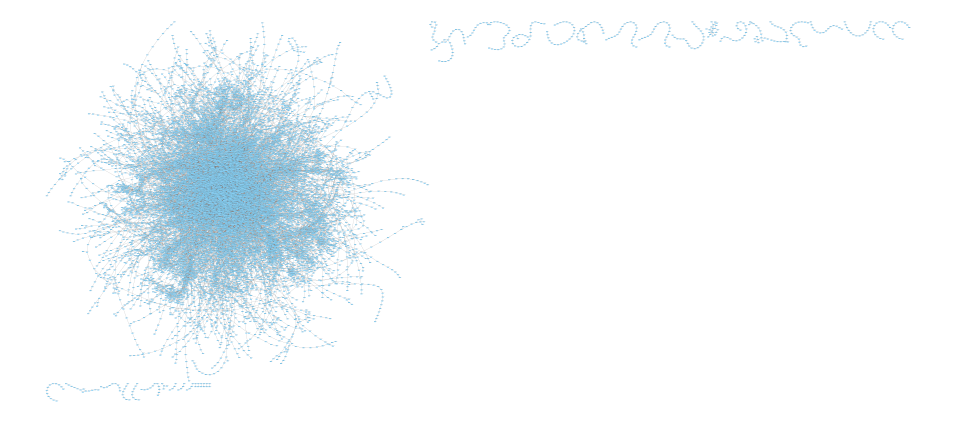

In [6]:
# display main network
p4c.notebook_export_show_image()

# Querying the Network

In [6]:
# How many clusters:
print('There is: {} clusters (nodes).'.format(len(nodes.id)))

There is: 16357 clusters (nodes).


In [7]:
# How many clusters are defense systems components (padloc/defesefinder prediction)
count = nodes.query('(dfs_prediction == dfs_prediction)').query('dfs_prediction != "NA"').shape[0]
print('Defense systems clusters: {}.'.format(count))

Defense systems clusters: 2719.


In [18]:
# Checking if the system naming is concistent between padloc and defesefinder (it is not, see the pie charts bellow)
defense_pred_df = (nodes
 .query('(dfs_prediction == dfs_prediction)')
 .query('dfs_prediction != "NA"')
 .loc[:,['id', 'dfs_prediction']]
 .assign(dfs_prediction = lambda df: df.dfs_prediction.str.split(';'))
 .explode('dfs_prediction')
 .query('dfs_prediction != "NA"')
 .assign(pred_name = lambda df: df.dfs_prediction.apply(lambda pred: re.findall('(?<=name\=).+?(?=\,)', pred)[0]))
 .assign(pred_sys  = lambda df: df.dfs_prediction.apply(lambda pred: re.findall('(?<=system\=).+?$', pred)[0]))
 .assign(tool  = lambda df: df.dfs_prediction.apply(lambda pred: re.findall('^[^:]+', pred)[0]))
 .drop('dfs_prediction', axis=1)
)
defense_pred_df.head()

,id,pred_name,pred_sys,tool
0,LHMLBOEB_03555,MTase_III,DMS_other,padloc
0,LHMLBOEB_03555,Type_III_MTases,RM,defensefinder
4,HBDDAOCK_04993,Type_III_REases,RM,defensefinder
8,MICPLNNG_02422,oMTase,DMS_other,padloc
16,EOLGGLMG_01167,REase_II,DMS_other,padloc


In [20]:
color_pallet = defaultdict(lambda: "#%06x" % random.randint(0, 0xFFFFFF))
color_pallet['OTHER'] = '#545454'

In [21]:
top_nt = 10
defense_finder_system_count = (defense_pred_df
                               .query('tool == "defensefinder"')
                               .groupby('pred_sys', as_index=False)
                               .size()
                               .sort_values('size', ascending=False))

defense_finder_system_count_plot = pd.concat(
    [
        defense_finder_system_count.head(top_nt),
        pd.DataFrame([('Other', defense_finder_system_count.query('size < @defense_finder_system_count.head(@top_nt).tail(1).values[0][-1]')['size'].sum())], columns=['pred_sys', 'size'])
    ]).reset_index(drop=True)

colors = tuple(map(lambda x: color_pallet[x.upper()], defense_finder_system_count_plot.pred_sys.values.tolist()))

padloc_system_count = (defense_pred_df
                               .query('tool == "padloc"')
                               .groupby('pred_sys', as_index=False)
                               .size()
                               .sort_values('size', ascending=False))

padloc_system_count_plot = pd.concat(
    [
        padloc_system_count.head(top_nt),
        pd.DataFrame([('Other', padloc_system_count.query('size < @padloc_system_count.head(@top_nt).tail(1).values[0][-1]')['size'].sum())], columns=['pred_sys', 'size'])
    ]).reset_index(drop=True)

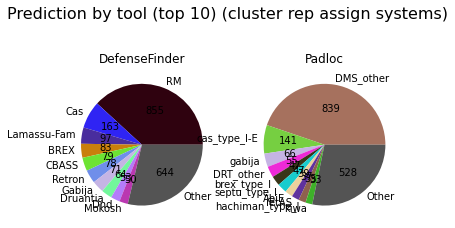

In [22]:
fig, axes = plt.subplots(1, 2)

axes[0].pie(defense_finder_system_count_plot['size'],
             labels =defense_finder_system_count_plot.pred_sys,
             colors=tuple(map(lambda x: color_pallet[x.upper()], defense_finder_system_count_plot.pred_sys.values.tolist())),
             autopct=lambda x: int(x * defense_finder_system_count_plot['size'].sum() / 100)
           )

axes[1].pie(padloc_system_count_plot['size'],
             labels =padloc_system_count_plot.pred_sys,
             colors=tuple(map(lambda x: color_pallet[x.upper()], padloc_system_count_plot.pred_sys.values.tolist())),
             autopct=lambda x: int(x * padloc_system_count_plot['size'].sum() / 100)
           )

_ = axes[0].set_title('DefenseFinder')
_ = axes[1].set_title('Padloc')
_ = fig.suptitle('Prediction by tool (top 10) (cluster rep assign systems)', fontsize=16)



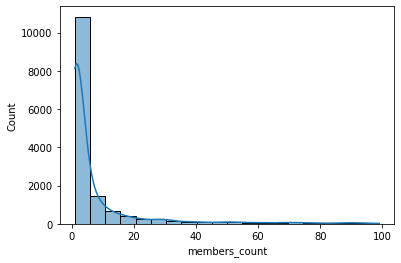

In [35]:
# how many members each clusters have ?
clust_members_count_fig = sns.histplot(data=nodes.query('members_count < 100'), x="members_count", bins=20, kde=True)
# clust_members_count_fig.set(xlabel='Cluster size (members count)', ylabel='n Members')

[Text(0.5, 0, 'Edge count'), Text(0, 0.5, 'n Edges')]

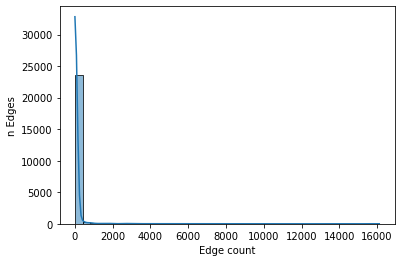

In [13]:
# Edge count distribution
edge_count_fig = sns.histplot(data=edges, x="edge_count", bins=40, kde=True)
edge_count_fig.set(xlabel='Edge count', ylabel='n Edges')

## Network filtering 
Let's build a subnetwork with fewers nodes to make things easer. Lets also color and format things.

In [56]:
# Let us define some filter parameters:
# The majority of the clustes seems to have at leat around 500 members, 
# let us remove the clusters with less than that 

# sub_nodes = [i for i in sub_nodes if not i in defese_clusters]
# sub_edges = [SUID for SUID, source, target in sub_edges if not any(map(lambda x: x in defese_clusters, [source, target]))]

defese_clusters = p4c.get_table_columns(table='node').query('dfs_prediction.str.contains(":", na=False)').id.values.tolist()

min_node_size = 500
sub_nodes = p4c.get_table_columns(table='node').query('id in @defese_clusters or members_count > @min_node_size').id.values.tolist()

# The majority of the edges also pick around ~500, so im going to use 500 to filter edges as well. 
min_edge_count = 500
sub_edges = p4c.get_table_columns(table='edge').query('(target in @defese_clusters or source in @defese_clusters) or edge_count > @min_edge_count').SUID.values.tolist()

In [50]:
p4c.create_subnetwork(nodes=sub_nodes, edges=sub_edges, subnetwork_name="Salmonella Bacterial Immunity FILTERED")

203691

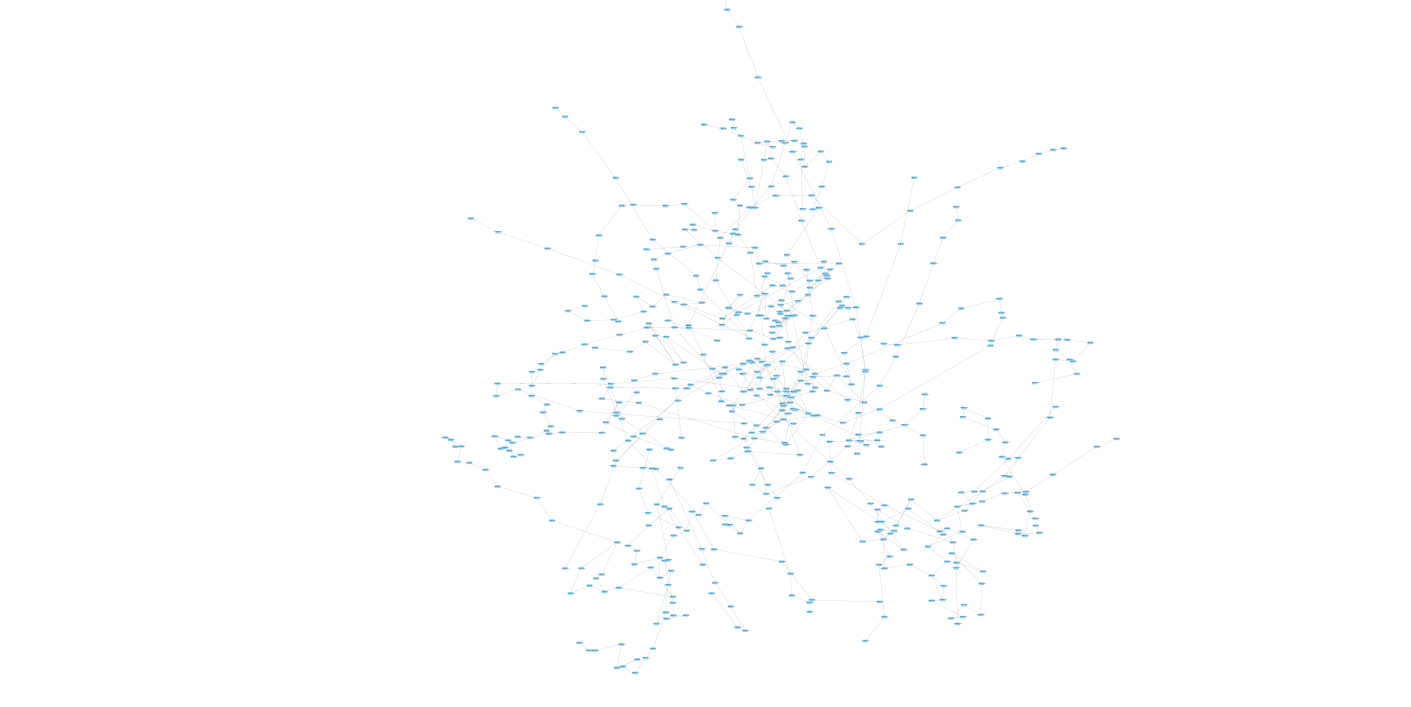

In [19]:
# After filterend the network shuld look somenthing like this 
p4c.notebook_export_show_image()

In [51]:
# Things are still a little bit fuzzy
# lets add size to nodes

# corr node size to be proportional to 300 (member_count * 300/max_member_count)
p4c.load_table_data(p4c.get_table_columns()
                    .assign(normalized_members_count = lambda df: tuple(map(lambda x: max(10, int(x*300/df.members_count.max())), df.members_count.values)))
                    .loc[:,['id', 'normalized_members_count']]
                    .set_index('id', drop=True), table='node')

style_name = "myStyle"
defaults = {'NODE_SHAPE': "ELLIPSE", 'NODE_SIZE': 10, 'NODE_FILL_COLOR' : '#7b8fba'}
node_labels = p4c.map_visual_property('node label', 'id', 'p') 
node_size_map = p4c.map_visual_property('NODE_SIZE', 'normalized_members_count', 'p')
p4c.create_visual_style(style_name, defaults, [node_size_map, node_labels])
p4c.set_visual_style(style_name)

{'message': 'Visual Style applied.'}

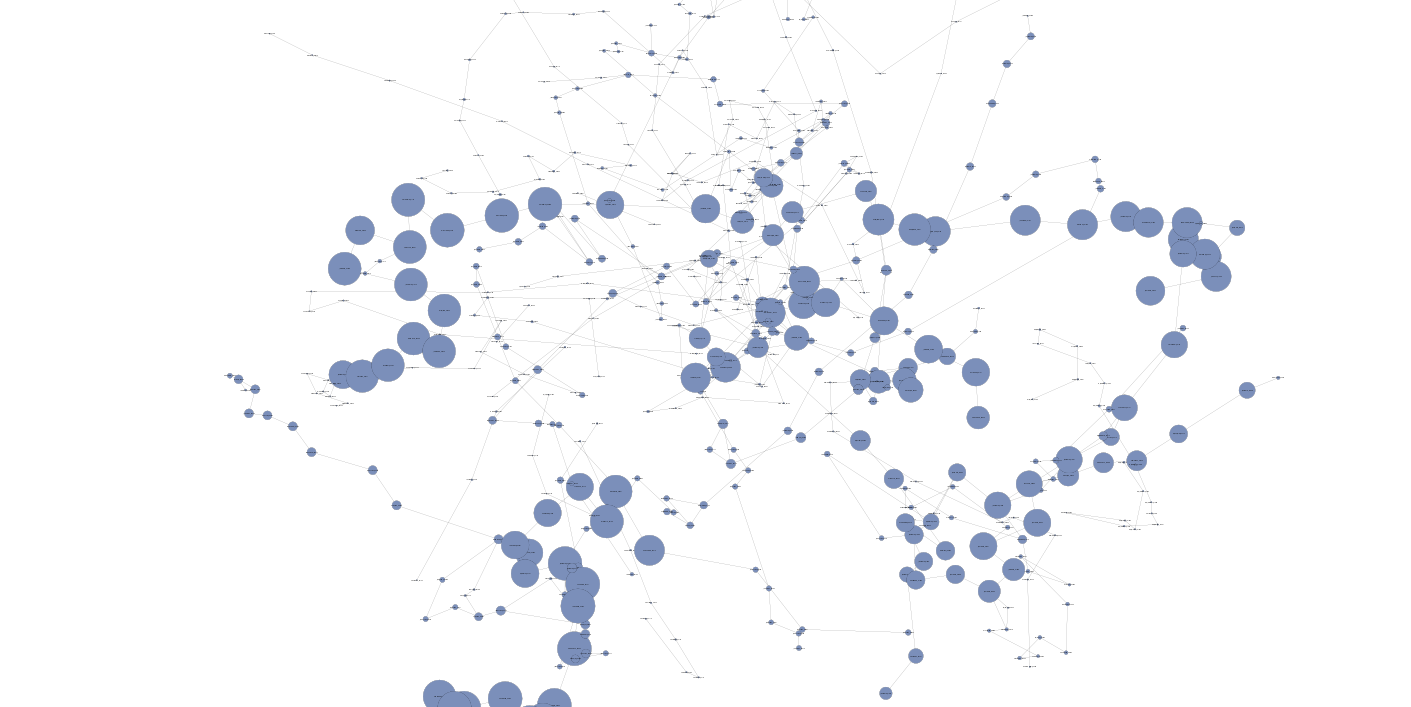

In [40]:
p4c.notebook_export_show_image()

In [52]:
# Now lets add a little color 
# Will use the DefesenseFinder prediction bc it was more concistence 
# Clusters that dont have the DefesenseFinder prediction i will use the padloc one
# (Both can be seen by clicking in the node at GUI)

# Get color to map
color_df = (pd.concat([
    defense_pred_df.query('tool == "padloc"')[~defense_pred_df.query('tool == "padloc"').id.isin(defense_pred_df.query('tool == "defensefinder"').id)],
    defense_pred_df.query('tool == "defensefinder"')[~defense_pred_df.query('tool == "defensefinder"').id.isin(defense_pred_df.query('tool == "padloc"').id)],
    defense_pred_df.query('tool == "defensefinder"')[defense_pred_df.query('tool == "defensefinder"').id.isin(defense_pred_df.query('tool == "padloc"').id)],
])
    .assign(color = lambda df: df.pred_sys.apply(lambda x: color_pallet.get(x.upper()) if color_pallet.get(x.upper()) else color_pallet.get('OTHER') ))
    .loc[:,['id', 'color']]
    .set_index('id', drop=True)
   )

NODE_FILL_COLOR = p4c.map_visual_property('node fill color', 'name', 'd', color_df.index.values.tolist(), color_df.color.values.tolist())

In [53]:
p4c.update_style_mapping('myStyle', NODE_FILL_COLOR)
p4c.set_visual_style('myStyle')

{'message': 'Visual Style applied.'}

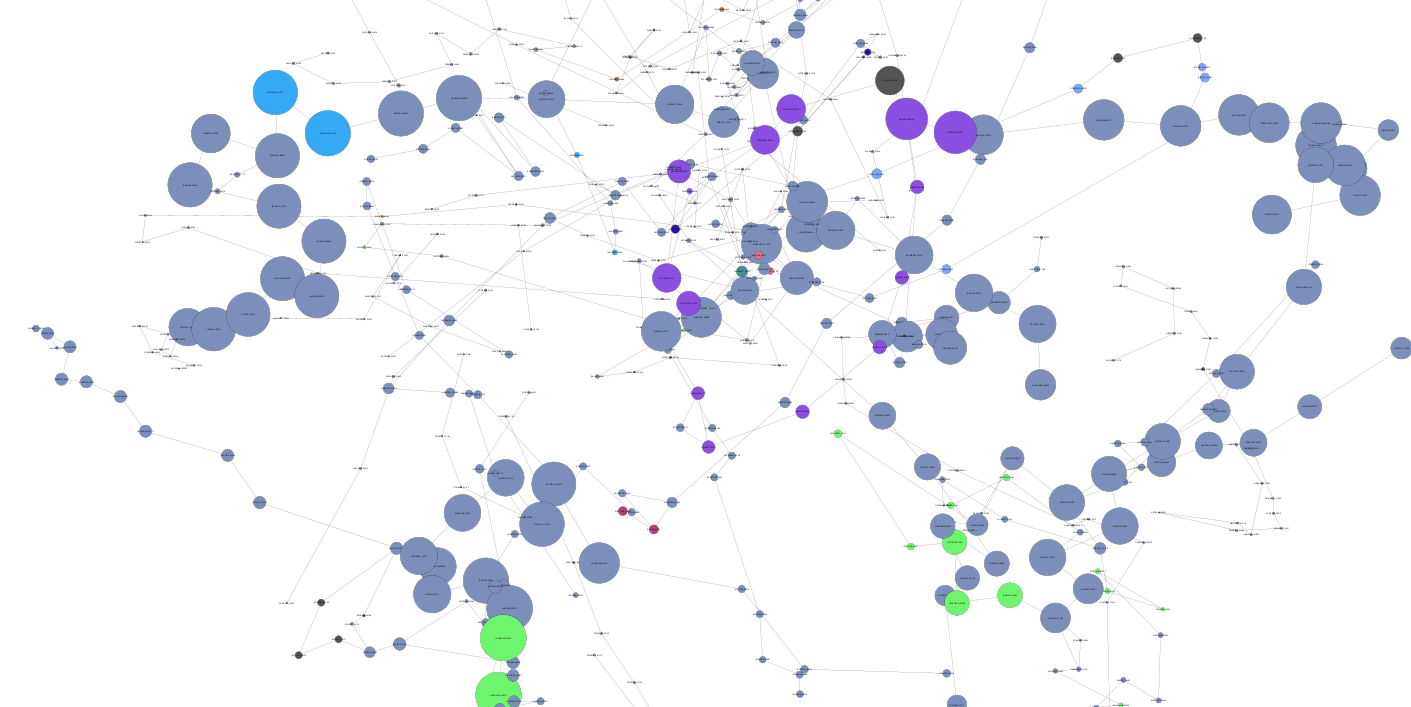

In [91]:
p4c.notebook_export_show_image()

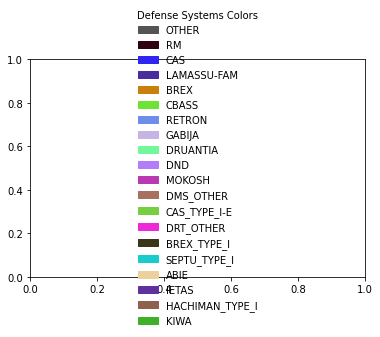

In [54]:
# To help visualization lets do a legend bar plot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

plt.legend(
    handles=[mpatches.Patch(color=color, label=system)  for system, color in color_pallet.items()],
    loc='center', frameon=False, title='Defense Systems Colors'
)

In [119]:
# Now that we have a fomated and filtered network
# we can apply a layout to see more clearly the relationships between the clusters
# that are a lot of layouts to choose from 
p4c.get_layout_names()

['attribute-circle',
 'stacked-node-layout',
 'attribute-grid',
 'degree-circle',
 'circular',
 'attributes-layout',
 'kamada-kawai',
 'force-directed',
 'cose',
 'grid',
 'hierarchical',
 'fruchterman-rheingold',
 'isom']

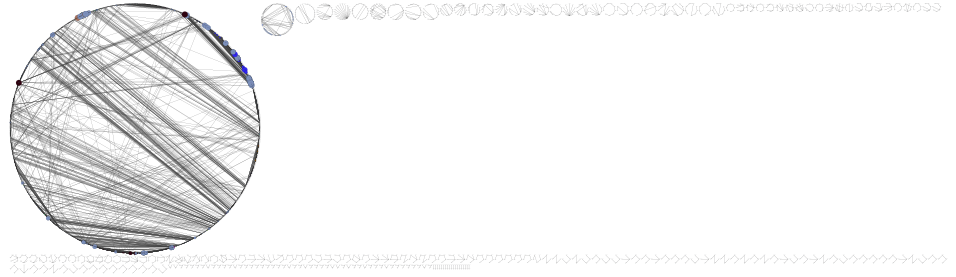

In [55]:
# I like this one bc it looks like pĺasmids 
p4c.layout_network('attribute-circle')
p4c.notebook_export_show_image()